In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *

simplefilter(action='ignore', category=FutureWarning)

# Compare the climatology of precipitation and scaling

In [2]:
era5_prec_hist_global = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist_global = era5_prec_hist_global.data
era5_prec_hist_global = era5_prec_hist_global.sel(time=slice('1960','2014'))
era5_prec_hist_global = era5_prec_hist_global['prec_cond'].mean(axis=0,skipna=True)

era5_scaling_hist_global = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
era5_scaling_hist_global = era5_scaling_hist_global.data
era5_scaling_hist_global = era5_scaling_hist_global.sel(time=slice('1960','2014'))
era5_scaling_hist_global = era5_scaling_hist_global['scaling'].mean(axis=0,skipna=True)

era5_prec_hist_hadex = Rx1dayCond('prec','era5','era5','reanalysis',mask='Global')
era5_prec_hist_hadex = era5_prec_hist_hadex.regrid()
era5_prec_hist_hadex = era5_prec_hist_hadex.sel(time=slice('1960','2014'))
era5_prec_hist_hadex = era5_prec_hist_hadex['prec_cond'].mean(axis=0,skipna=True)

era5_scaling_hist_hadex = Rx1dayCond('scaling','era5','era5','reanalysis',mask='Global')
era5_scaling_hist_hadex = era5_scaling_hist_hadex.regrid()
era5_scaling_hist_hadex = era5_scaling_hist_hadex.sel(time=slice('1960','2014'))
era5_scaling_hist_hadex = era5_scaling_hist_hadex['scaling'].mean(axis=0,skipna=True)

In [3]:
jra55_prec_hist_global = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist_global = jra55_prec_hist_global.data
jra55_prec_hist_global = jra55_prec_hist_global.sel(time=slice('1960','2014'))
jra55_prec_hist_global = jra55_prec_hist_global['prec_cond'].mean(axis=0,skipna=True)

jra55_scaling_hist_global = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
jra55_scaling_hist_global = jra55_scaling_hist_global.data
jra55_scaling_hist_global = jra55_scaling_hist_global.sel(time=slice('1960','2014'))
jra55_scaling_hist_global = jra55_scaling_hist_global['scaling'].mean(axis=0,skipna=True)

jra55_prec_hist_hadex = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='Global')
jra55_prec_hist_hadex = jra55_prec_hist_hadex.regrid()
jra55_prec_hist_hadex = jra55_prec_hist_hadex.sel(time=slice('1960','2014'))
jra55_prec_hist_hadex = jra55_prec_hist_hadex['prec_cond'].mean(axis=0,skipna=True)

jra55_scaling_hist_hadex = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='Global')
jra55_scaling_hist_hadex = jra55_scaling_hist_hadex.regrid()
jra55_scaling_hist_hadex = jra55_scaling_hist_hadex.sel(time=slice('1960','2014'))
jra55_scaling_hist_hadex = jra55_scaling_hist_hadex['scaling'].mean(axis=0,skipna=True)

In [4]:
era5_prec_scaling_corr_global = xr.corr(era5_prec_hist_global,era5_scaling_hist_global).values.tolist()
era5_prec_scaling_corr_hadex  = xr.corr(era5_prec_hist_hadex, era5_scaling_hist_hadex).values.tolist()
jra55_prec_scaling_corr_global = xr.corr(jra55_prec_hist_global,jra55_scaling_hist_global).values.tolist()
jra55_prec_scaling_corr_hadex  = xr.corr(jra55_prec_hist_hadex, jra55_scaling_hist_hadex).values.tolist()

In [5]:
name_ens = 'prec'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]

In [6]:
prec_scaling_corr_global = []
prec_scaling_corr_hadex  = []

prec_hist_mme_global = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
scaling_hist_mme_global = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
prec_hist_mme_hadex = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
scaling_hist_mme_hadex = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i_prec = Rx1dayCond('prec',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    ens_i_prec = ens_i_prec.regrid()
    ens_i_prec = ens_i_prec['prec_cond']
    ens_i_prec = ens_i_prec.sel(time=slice('1960','2014'))
    ens_i_prec = ens_i_prec.mean(axis=0,skipna=True)
    prec_hist_mme_global[x,:,:] = ens_i_prec

    ens_i_scaling = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    ens_i_scaling = ens_i_scaling.regrid()
    ens_i_scaling = ens_i_scaling['scaling']
    ens_i_scaling = ens_i_scaling.sel(time=slice('1960','2014'))
    ens_i_scaling = ens_i_scaling.mean(axis=0,skipna=True)
    scaling_hist_mme_global[x,:,:] = ens_i_scaling
    
    prec_scaling_corr_global.append(xr.corr(ens_i_prec,ens_i_scaling).values.tolist())

    ens_i_prec = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_prec = ens_i_prec.regrid()
    ens_i_prec = ens_i_prec['prec_cond']
    ens_i_prec = ens_i_prec.sel(time=slice('1960','2014'))
    ens_i_prec = ens_i_prec.mean(axis=0,skipna=True)
    prec_hist_mme_hadex[x,:,:] = ens_i_prec

    ens_i_scaling = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_scaling = ens_i_scaling.regrid()
    ens_i_scaling = ens_i_scaling['scaling']
    ens_i_scaling = ens_i_scaling.sel(time=slice('1960','2014'))
    ens_i_scaling = ens_i_scaling.mean(axis=0,skipna=True)
    scaling_hist_mme_hadex[x,:,:] = ens_i_scaling 

    prec_scaling_corr_hadex.append(xr.corr(ens_i_prec,ens_i_scaling).values.tolist())

prec_hist_mme_global = prec_hist_mme_global.mean(axis=0)
scaling_hist_mme_global = scaling_hist_mme_global.mean(axis=0)
prec_hist_mme_hadex = prec_hist_mme_hadex.mean(axis=0)
scaling_hist_mme_hadex = scaling_hist_mme_hadex.mean(axis=0)

prec_hist_mme_global = xr.DataArray(data=prec_hist_mme_global,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
scaling_hist_mme_global = xr.DataArray(data=scaling_hist_mme_global,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
prec_hist_mme_hadex = xr.DataArray(data=prec_hist_mme_hadex,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
scaling_hist_mme_hadex = xr.DataArray(data=scaling_hist_mme_hadex,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))

prec_scaling_corr_mme_global = xr.corr(prec_hist_mme_global,scaling_hist_mme_global).values.tolist()
prec_scaling_corr_mme_hadex  = xr.corr(prec_hist_mme_hadex ,scaling_hist_mme_hadex).values.tolist()

In [9]:
ensemble_names = [i.split('_')[0] + '_' + i.split('_')[2] for i in ensemble]
prec_scaling_corr = pd.DataFrame({'Global':prec_scaling_corr_global,'HadEX3_region':prec_scaling_corr_hadex},index=ensemble_names)
prec_scaling_corr_era5 = pd.DataFrame({'Global':era5_prec_scaling_corr_global,'HadEX3_region':era5_prec_scaling_corr_hadex},index=['ERA5'])
prec_scaling_corr_jra55 = pd.DataFrame({'Global':jra55_prec_scaling_corr_global,'HadEX3_region':jra55_prec_scaling_corr_hadex},index=['JRA55'])
prec_scaling_corr_mme = pd.DataFrame({'Global':prec_scaling_corr_mme_global,'HadEX3_region':prec_scaling_corr_mme_hadex},index=['Multi-model mean'])
prec_scaling_corr = pd.concat([prec_scaling_corr,prec_scaling_corr_era5,prec_scaling_corr_jra55,prec_scaling_corr_mme],axis=0)
prec_scaling_corr = prec_scaling_corr.sort_values(by=['Global'],ascending=False)
prec_scaling_corr

,Global,HadEX3_region
ACCESS-CM2_r1i1p1f1,0.994826,0.989834
ACCESS-ESM1-5_r1i1p1f1,0.994402,0.983688
CanESM5_r1i1p1f1,0.993461,0.977228
CanESM5_r2i1p1f1,0.993433,0.977143
CanESM5_r3i1p1f1,0.993429,0.977349
CanESM5_r4i1p1f1,0.993379,0.976098
CanESM5_r5i1p1f1,0.993353,0.976439
MIROC6_r1i1p1f1,0.993086,0.988976
Multi-model mean,0.992469,0.981249
JRA55,0.990435,0.958015


# Compare the changing trend of precipitation and scaling

In [11]:
era5_prec_hist_global = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist_global = era5_prec_hist_global.data
era5_prec_hist_global = era5_prec_hist_global.sel(time=slice('1960','2014'))
era5_prec_hist_global_trend = trend_cal(era5_prec_hist_global['prec_cond'])

era5_scaling_hist_global = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
era5_scaling_hist_global = era5_scaling_hist_global.data
era5_scaling_hist_global = era5_scaling_hist_global.sel(time=slice('1960','2014'))
era5_scaling_hist_global_trend = trend_cal(era5_scaling_hist_global['scaling'])

era5_prec_hist_hadex = Rx1dayCond('prec','era5','era5','reanalysis',mask='Global')
era5_prec_hist_hadex = era5_prec_hist_hadex.regrid()
era5_prec_hist_hadex = era5_prec_hist_hadex.sel(time=slice('1960','2014'))
era5_prec_hist_hadex_trend = trend_cal(era5_prec_hist_hadex['prec_cond'])

era5_scaling_hist_hadex = Rx1dayCond('scaling','era5','era5','reanalysis',mask='Global')
era5_scaling_hist_hadex = era5_scaling_hist_hadex.regrid()
era5_scaling_hist_hadex = era5_scaling_hist_hadex.sel(time=slice('1960','2014'))
era5_scaling_hist_hadex_trend = trend_cal(era5_scaling_hist_hadex['scaling'])

In [12]:
jra55_prec_hist_global = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist_global = jra55_prec_hist_global.data
jra55_prec_hist_global = jra55_prec_hist_global.sel(time=slice('1960','2014'))
jra55_prec_hist_global_trend = trend_cal(jra55_prec_hist_global['prec_cond'])

jra55_scaling_hist_global = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
jra55_scaling_hist_global = jra55_scaling_hist_global.data
jra55_scaling_hist_global = jra55_scaling_hist_global.sel(time=slice('1960','2014'))
jra55_scaling_hist_global_trend = trend_cal(jra55_scaling_hist_global['scaling'])

jra55_prec_hist_hadex = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='Global')
jra55_prec_hist_hadex = jra55_prec_hist_hadex.regrid()
jra55_prec_hist_hadex = jra55_prec_hist_hadex.sel(time=slice('1960','2014'))
jra55_prec_hist_hadex_trend = trend_cal(jra55_prec_hist_hadex['prec_cond'])

jra55_scaling_hist_hadex = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='Global')
jra55_scaling_hist_hadex = jra55_scaling_hist_hadex.regrid()
jra55_scaling_hist_hadex = jra55_scaling_hist_hadex.sel(time=slice('1960','2014'))
jra55_scaling_hist_hadex_trend = trend_cal(jra55_scaling_hist_hadex['scaling'])

In [13]:
era5_prec_scaling_trend_corr_global = xr.corr(era5_prec_hist_global_trend,era5_scaling_hist_global_trend).values.tolist()
era5_prec_scaling_trend_corr_hadex  = xr.corr(era5_prec_hist_hadex_trend, era5_scaling_hist_hadex_trend).values.tolist()
jra55_prec_scaling_trend_corr_global = xr.corr(jra55_prec_hist_global_trend,jra55_scaling_hist_global_trend).values.tolist()
jra55_prec_scaling_trend_corr_hadex  = xr.corr(jra55_prec_hist_hadex_trend, jra55_scaling_hist_hadex_trend).values.tolist()

In [14]:
prec_scaling_trend_corr_global = []
prec_scaling_trend_corr_hadex  = []

prec_hist_trend_mme_global = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
scaling_hist_trend_mme_global = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
prec_hist_trend_mme_hadex = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))
scaling_hist_trend_mme_hadex = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i_prec = Rx1dayCond('prec',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    ens_i_prec = ens_i_prec.regrid()
    ens_i_prec = ens_i_prec['prec_cond']
    ens_i_prec = ens_i_prec.sel(time=slice('1960','2014'))
    ens_i_prec_trend = trend_cal(ens_i_prec)
    prec_hist_trend_mme_global[x,:,:] = ens_i_prec_trend

    ens_i_scaling = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    ens_i_scaling = ens_i_scaling.regrid()
    ens_i_scaling = ens_i_scaling['scaling']
    ens_i_scaling = ens_i_scaling.sel(time=slice('1960','2014'))
    ens_i_scaling_trend = trend_cal(ens_i_scaling)
    scaling_hist_trend_mme_global[x,:,:] = ens_i_scaling_trend
    
    prec_scaling_trend_corr_global.append(xr.corr(ens_i_prec_trend,ens_i_scaling_trend).values.tolist())

    ens_i_prec = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_prec = ens_i_prec.regrid()
    ens_i_prec = ens_i_prec['prec_cond']
    ens_i_prec = ens_i_prec.sel(time=slice('1960','2014'))
    ens_i_prec_trend = trend_cal(ens_i_prec)
    prec_hist_trend_mme_hadex[x,:,:] = ens_i_prec_trend

    ens_i_scaling = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_scaling = ens_i_scaling.regrid()
    ens_i_scaling = ens_i_scaling['scaling']
    ens_i_scaling = ens_i_scaling.sel(time=slice('1960','2014'))
    ens_i_scaling_trend = trend_cal(ens_i_scaling)
    scaling_hist_trend_mme_hadex[x,:,:] = ens_i_scaling_trend

    prec_scaling_trend_corr_hadex.append(xr.corr(ens_i_prec_trend,ens_i_scaling_trend).values.tolist())

prec_hist_trend_mme_global = prec_hist_trend_mme_global.mean(axis=0)
scaling_hist_trend_mme_global = scaling_hist_trend_mme_global.mean(axis=0)
prec_hist_trend_mme_hadex = prec_hist_trend_mme_hadex.mean(axis=0)
scaling_hist_trend_mme_hadex = scaling_hist_trend_mme_hadex.mean(axis=0)

prec_hist_trend_mme_global = xr.DataArray(data=prec_hist_trend_mme_global,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
scaling_hist_trend_mme_global = xr.DataArray(data=scaling_hist_trend_mme_global,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
prec_hist_trend_mme_hadex = xr.DataArray(data=prec_hist_trend_mme_hadex,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))
scaling_hist_trend_mme_hadex = xr.DataArray(data=scaling_hist_trend_mme_hadex,dims=['lat','lon'],coords=dict(lon = hadex_rx1day_grid_sel['lon'], lat = hadex_rx1day_grid_sel['lat']))

prec_scaling_trend_corr_mme_global = xr.corr(prec_hist_trend_mme_global,scaling_hist_trend_mme_global).values.tolist()
prec_scaling_trend_corr_mme_hadex  = xr.corr(prec_hist_trend_mme_hadex ,scaling_hist_trend_mme_hadex).values.tolist()

In [15]:
np.array(prec_scaling_trend_corr_hadex)

array([0.9550018 , 0.92354916, 0.82166496, 0.68335962, 0.91653057,
       0.91437277, 0.90448522, 0.91999364, 0.91176262, 0.91479957,
       0.92979862, 0.88069525, 0.88540316, 0.86568434, 0.90066787,
       0.87471472, 0.85162045, 0.80304513, 0.92772824, 0.76945467,
       0.84744405, 0.82883556, 0.89513052, 0.83058943])

In [16]:
np.array(prec_scaling_trend_corr_global)

array([0.97311497, 0.95576408, 0.81061929, 0.69005577, 0.92563444,
       0.91463801, 0.91775861, 0.93626569, 0.92936734, 0.91448496,
       0.92770832, 0.88916955, 0.8940174 , 0.89612758, 0.90076102,
       0.8955944 , 0.94740291, 0.84339047, 0.93430942, 0.78837148,
       0.84905058, 0.81076133, 0.93021243, 0.88872319])

In [17]:
prec_scaling_trend_corr_mme_global

0.927666456902281

In [18]:
prec_scaling_trend_corr_mme_hadex

0.9363058594143772

In [19]:
prec_scaling_trend_corr = pd.DataFrame({'Global':prec_scaling_trend_corr_global,'HadEX3_region':prec_scaling_trend_corr_hadex},index=ensemble_names)
prec_scaling_trend_corr_era5 = pd.DataFrame({'Global':era5_prec_scaling_trend_corr_global,'HadEX3_region':era5_prec_scaling_trend_corr_hadex},index=['ERA5'])
prec_scaling_trend_corr_jra55 = pd.DataFrame({'Global':jra55_prec_scaling_trend_corr_global,'HadEX3_region':jra55_prec_scaling_trend_corr_hadex},index=['JRA55'])
prec_scaling_trend_corr_mme = pd.DataFrame({'Global':prec_scaling_trend_corr_mme_global,'HadEX3_region':prec_scaling_trend_corr_mme_hadex},index=['Multi-model mean'])
prec_scaling_trend_corr = pd.concat([prec_scaling_trend_corr,prec_scaling_trend_corr_era5,prec_scaling_trend_corr_jra55,prec_scaling_trend_corr_mme],axis=0)
prec_scaling_trend_corr = prec_scaling_trend_corr.sort_values(by=['Global'],ascending=False)
prec_scaling_trend_corr

,Global,HadEX3_region
ACCESS-CM2_r1i1p1f1,0.973115,0.955002
JRA55,0.958479,0.882156
ACCESS-ESM1-5_r1i1p1f1,0.955764,0.923549
FGOALS-g3_r1i1p1f1,0.947403,0.851620
CESM2_r2i1p1f1,0.936266,0.919994
MIROC6_r1i1p1f1,0.934309,0.927728
MRI-ESM2-0_r1i1p1f1,0.930212,0.895131
CESM2_r3i1p1f1,0.929367,0.911763
CESM2_r5i1p1f1,0.927708,0.929799
Multi-model mean,0.927666,0.936306


# Plot

In [21]:
prec_scaling_corr_model = prec_scaling_corr.copy()
prec_scaling_corr_model['model'] = [i.split('_')[0] for i in prec_scaling_corr_model.index]
prec_scaling_corr_model = prec_scaling_corr_model.drop('CESM2_r1i1p1f1')
# exclude CESM2_r1i1p1f1 for its bad performance
prec_scaling_corr_model = prec_scaling_corr_model.groupby('model').mean()
prec_scaling_corr_model = prec_scaling_corr_model.sort_values('Global',ascending=True)
prec_scaling_corr_model

,Global,HadEX3_region
model,,
ERA5,0.971933,0.856751
AWI-ESM-1-1-LR,0.973128,0.937176
MPI-ESM-1-2-HAM,0.974232,0.944588
MPI-ESM1-2-LR,0.976253,0.948131
MPI-ESM1-2-HR,0.976846,0.943465
CESM2-WACCM,0.979096,0.963571
CESM2,0.979392,0.963787
MIROC-ES2L,0.980760,0.962270
CESM2-FV2,0.981349,0.971585


In [22]:
prec_scaling_trend_corr_model = prec_scaling_trend_corr.copy()
prec_scaling_trend_corr_model['model'] = [i.split('_')[0] for i in prec_scaling_trend_corr_model.index]
prec_scaling_trend_corr_model = prec_scaling_trend_corr_model.drop('CESM2_r1i1p1f1')
prec_scaling_trend_corr_model = prec_scaling_trend_corr_model.groupby('model').mean()
prec_scaling_trend_corr_model = prec_scaling_trend_corr_model.sort_values('Global',ascending=True)
prec_scaling_trend_corr_model

,Global,HadEX3_region
model,,
CAMS-CSM1-0,0.690056,0.683360
MPI-ESM-1-2-HAM,0.788371,0.769455
AWI-ESM-1-1-LR,0.810619,0.821665
MPI-ESM1-2-LR,0.810761,0.828836
MIROC-ES2L,0.843390,0.803045
MPI-ESM1-2-HR,0.849051,0.847444
NESM3,0.888723,0.830589
CanESM5,0.895134,0.881433
ERA5,0.895421,0.711422


In [23]:
prec_scaling_trend_corr

,Global,HadEX3_region
ACCESS-CM2_r1i1p1f1,0.973115,0.955002
JRA55,0.958479,0.882156
ACCESS-ESM1-5_r1i1p1f1,0.955764,0.923549
FGOALS-g3_r1i1p1f1,0.947403,0.851620
CESM2_r2i1p1f1,0.936266,0.919994
MIROC6_r1i1p1f1,0.934309,0.927728
MRI-ESM2-0_r1i1p1f1,0.930212,0.895131
CESM2_r3i1p1f1,0.929367,0.911763
CESM2_r5i1p1f1,0.927708,0.929799
Multi-model mean,0.927666,0.936306


In [24]:
prec_scaling_trend_corr_CanESM5 = prec_scaling_trend_corr.loc[[i.startswith('CanESM5') for i in prec_scaling_trend_corr.index]]
prec_scaling_trend_corr_CanESM5_top_global = prec_scaling_trend_corr_CanESM5.max(axis=0)['Global'] - prec_scaling_trend_corr_model.loc['CanESM5'][0]
prec_scaling_trend_corr_CanESM5_bot_global = prec_scaling_trend_corr_model.loc['CanESM5'][0] - prec_scaling_trend_corr_CanESM5.min(axis=0)['Global']
prec_scaling_trend_corr_CanESM5_top_hadex = prec_scaling_trend_corr_CanESM5.max(axis=0)['HadEX3_region'] - prec_scaling_trend_corr_model.loc['CanESM5'][1]
prec_scaling_trend_corr_CanESM5_bot_hadex = prec_scaling_trend_corr_model.loc['CanESM5'][1] - prec_scaling_trend_corr_CanESM5.min(axis=0)['HadEX3_region']

prec_scaling_corr_CanESM5 = prec_scaling_corr.loc[[i.startswith('CanESM5') for i in prec_scaling_corr.index]]
prec_scaling_corr_CanESM5_top_global = prec_scaling_corr_CanESM5.max(axis=0)['Global'] - prec_scaling_corr_model.loc['CanESM5'][0]
prec_scaling_corr_CanESM5_bot_global = prec_scaling_corr_model.loc['CanESM5'][0] - prec_scaling_corr_CanESM5.min(axis=0)['Global']
prec_scaling_corr_CanESM5_top_hadex = prec_scaling_corr_CanESM5.max(axis=0)['HadEX3_region'] - prec_scaling_corr_model.loc['CanESM5'][1]
prec_scaling_corr_CanESM5_bot_hadex = prec_scaling_corr_model.loc['CanESM5'][1] - prec_scaling_corr_CanESM5.min(axis=0)['HadEX3_region']

In [25]:
# prec_scaling_trend_corr = prec_scaling_trend_corr.drop('CESM2_r1i1p1f1')
prec_scaling_trend_corr_CESM2 = prec_scaling_trend_corr.loc[[i.startswith('CESM2_') for i in prec_scaling_trend_corr.index]]
prec_scaling_trend_corr_CESM2_top_global = prec_scaling_trend_corr_CESM2.max(axis=0)['Global'] - prec_scaling_trend_corr_model.loc['CESM2'][0]
prec_scaling_trend_corr_CESM2_bot_global = prec_scaling_trend_corr_model.loc['CESM2'][0] - prec_scaling_trend_corr_CESM2.min(axis=0)['Global']
prec_scaling_trend_corr_CESM2_top_hadex = prec_scaling_trend_corr_CESM2.max(axis=0)['HadEX3_region'] - prec_scaling_trend_corr_model.loc['CESM2'][1]
prec_scaling_trend_corr_CESM2_bot_hadex = prec_scaling_trend_corr_model.loc['CESM2'][1] - prec_scaling_trend_corr_CESM2.min(axis=0)['HadEX3_region']

# prec_scaling_corr = prec_scaling_corr.drop('CESM2_r1i1p1f1')
prec_scaling_corr_CESM2 = prec_scaling_corr.loc[[i.startswith('CESM2_') for i in prec_scaling_corr.index]]
prec_scaling_corr_CESM2_top_global = prec_scaling_corr_CESM2.max(axis=0)['Global'] - prec_scaling_corr_model.loc['CESM2'][0]
prec_scaling_corr_CESM2_bot_global = prec_scaling_corr_model.loc['CESM2'][0] - prec_scaling_corr_CESM2.min(axis=0)['Global']
prec_scaling_corr_CESM2_top_hadex = prec_scaling_corr_CESM2.max(axis=0)['HadEX3_region'] - prec_scaling_corr_model.loc['CESM2'][1]
prec_scaling_corr_CESM2_bot_hadex = prec_scaling_corr_model.loc['CESM2'][1] - prec_scaling_corr_CESM2.min(axis=0)['HadEX3_region']

/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_42487/49645391.py:44: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax.set_ylim([-0.8,18.8])
/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_42487/49645391.py:45: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax.set_xlabel('Spatial Correlation')
/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_42487/49645391.py:46: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax.grid(False)
/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_42487/49645391.py:48: ProplotWarning: fig.tight_layout() has no effect o

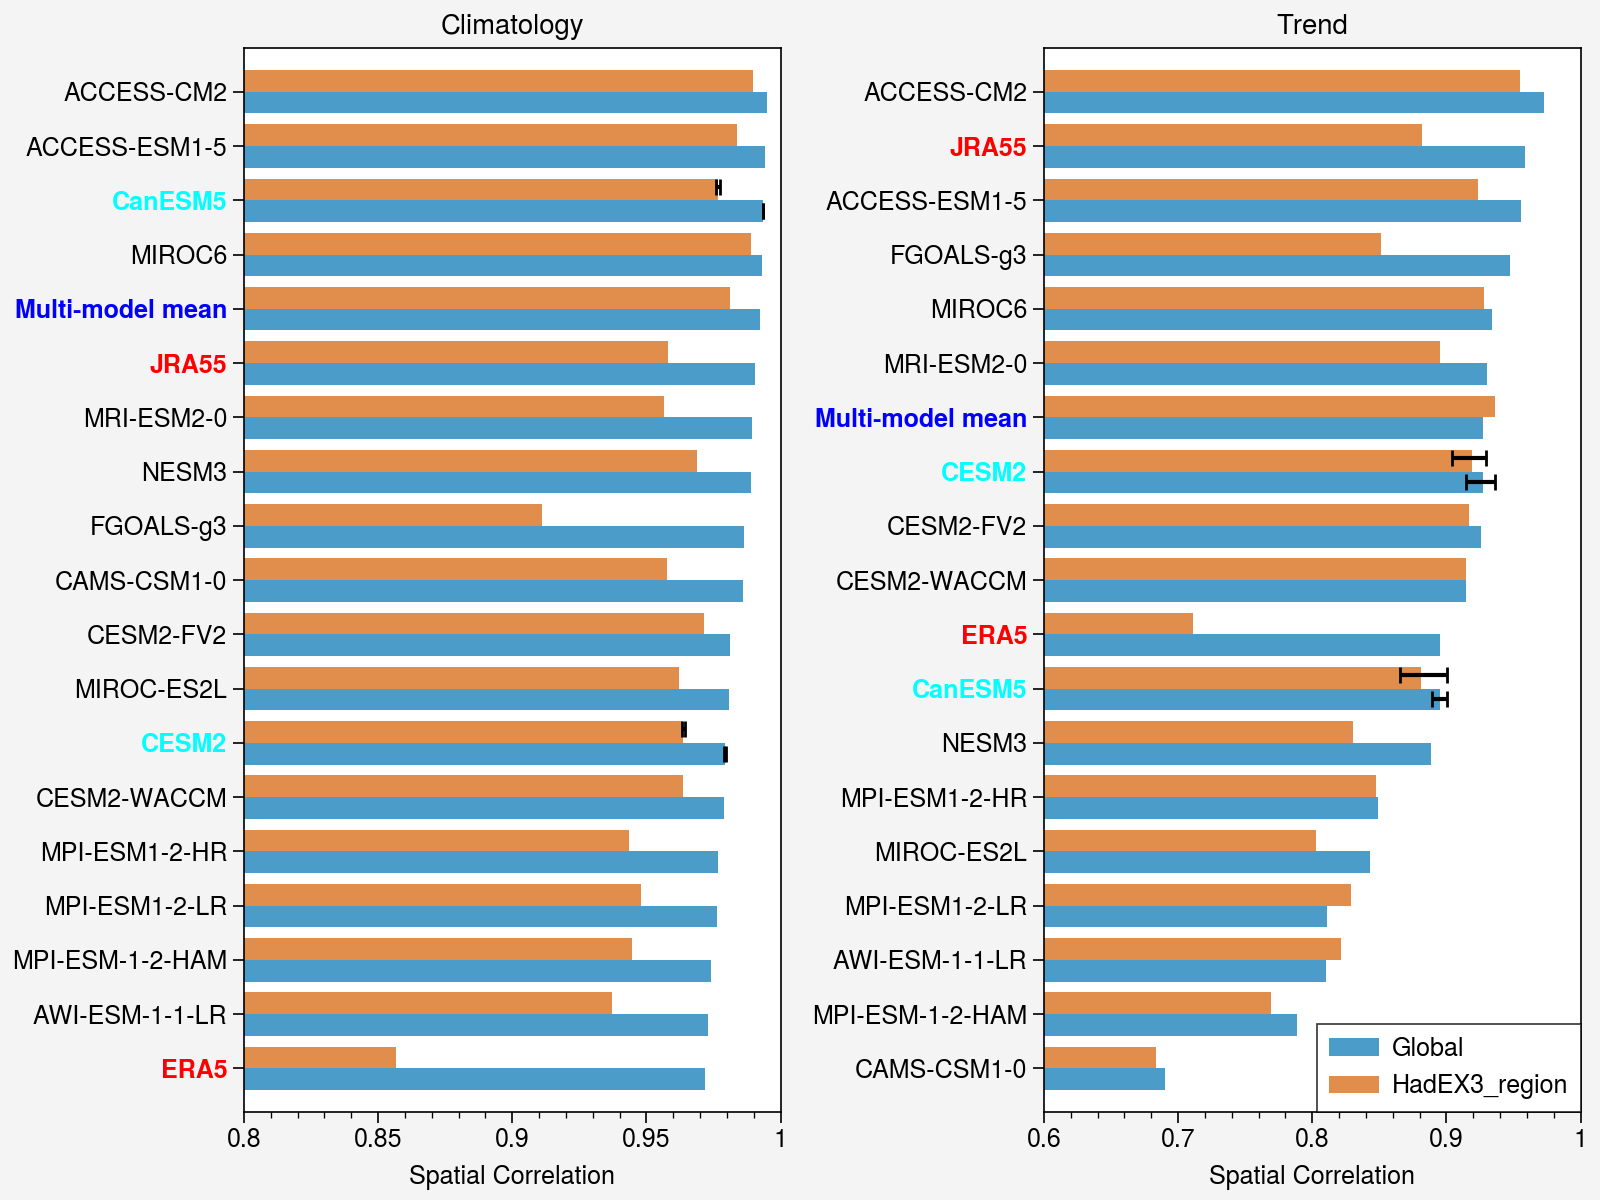

In [30]:
fig, ax = pplot.subplots(ncols = 2, nrows = 1, hspace=(1.8), width = 8, height = 6, share=0)
ax[0].barh(prec_scaling_corr_model,alpha=0.7) 
ax[0].set_xlim([0.8,1.])
ax[0].invert_yaxis()
ax[0].yaxis.label.set_visible(False)
ax[0].set_title('Climatology')
ax[0].errorbar(y=[16+0.25],x=[prec_scaling_corr_model.loc['CanESM5'][1]],xerr=([prec_scaling_corr_CanESM5_bot_hadex],[prec_scaling_corr_CanESM5_top_hadex]),color='black')
ax[0].errorbar(y=[16-0.2],x=[prec_scaling_corr_model.loc['CanESM5'][0]],xerr=([prec_scaling_corr_CanESM5_bot_global],[prec_scaling_corr_CanESM5_top_global]),color='black')
ax[0].errorbar(y=[6+0.25],x=[prec_scaling_corr_model.loc['CESM2'][1]],xerr=([prec_scaling_corr_CESM2_bot_hadex],[prec_scaling_corr_CESM2_top_hadex]),color='black')
ax[0].errorbar(y=[6-0.2],x=[prec_scaling_corr_model.loc['CESM2'][0]],xerr=([prec_scaling_corr_CESM2_bot_global],[prec_scaling_corr_CESM2_top_global]),color='black')
ax[0].get_yticklabels()[0].set_color("red")
ax[0].get_yticklabels()[0].set_fontweight("bold")
ax[0].get_yticklabels()[-6].set_color("red")
ax[0].get_yticklabels()[-6].set_fontweight("bold")
ax[0].get_yticklabels()[-5].set_color("blue")
ax[0].get_yticklabels()[-5].set_fontweight("bold")
ax[0].get_yticklabels()[-3].set_color("cyan")
ax[0].get_yticklabels()[-3].set_fontweight("bold")
ax[0].get_yticklabels()[6].set_color("cyan")
ax[0].get_yticklabels()[6].set_fontweight("bold")

p = ax[1].barh(prec_scaling_trend_corr_model,alpha=0.7)
ax[1].set_xlim([0.6,1.])
ax[1].invert_yaxis()
ax[1].yaxis.label.set_visible(False)
ax[1].set_title('Trend')
ax[1].errorbar(y=[7+0.25],x=[prec_scaling_trend_corr_model.loc['CanESM5'][1]],xerr=([prec_scaling_trend_corr_CanESM5_bot_hadex],[prec_scaling_trend_corr_CanESM5_top_hadex]),color='black')
ax[1].errorbar(y=[7-0.2],x=[prec_scaling_trend_corr_model.loc['CanESM5'][0]],xerr=([prec_scaling_trend_corr_CanESM5_bot_global],[prec_scaling_trend_corr_CanESM5_top_global]),color='black')
ax[1].errorbar(y=[11+0.25],x=[prec_scaling_trend_corr_model.loc['CESM2'][1]],xerr=([prec_scaling_trend_corr_CESM2_bot_hadex],[prec_scaling_trend_corr_CESM2_top_hadex]),color='black')
ax[1].errorbar(y=[11-0.2],x=[prec_scaling_trend_corr_model.loc['CESM2'][0]],xerr=([prec_scaling_trend_corr_CESM2_bot_global],[prec_scaling_trend_corr_CESM2_top_global]),color='black')
ax[1].legend(loc='lower right',ncol=1,frameon='False')
ax[1].get_yticklabels()[8].set_color("red")
ax[1].get_yticklabels()[8].set_fontweight("bold")
ax[1].get_yticklabels()[-2].set_color("red")
ax[1].get_yticklabels()[-2].set_fontweight("bold")
ax[1].get_yticklabels()[-7].set_color("blue")
ax[1].get_yticklabels()[-7].set_fontweight("bold")
ax[1].get_yticklabels()[7].set_color("cyan")
ax[1].get_yticklabels()[7].set_fontweight("bold")
ax[1].get_yticklabels()[-8].set_color("cyan")
ax[1].get_yticklabels()[-8].set_fontweight("bold")

ax.set_ylim([-0.8,18.8])
ax.set_xlabel('Spatial Correlation')
ax.grid(False)
plt.tight_layout()

dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
plt.savefig(dir+'FigureS3_spatial_correlation_Rx1day_scaling.pdf',dpi = 100)